# Anomaly Detection and Active Learning

In this notebook, you will get familiar with Anomaly Detection and Active Learning.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Data: Artificial Dataset

For this session we generate our own dataset. Because the goal is to plot the data along with the next steps, the dataset will have only 2 features. In Anomaly Detection the majority of the data is considered as normal, while anomalies represent a small percentage of the total amount. Here, we will set the proportion of normal examples to 95% (class prior).

In [14]:
np.random.seed(1)
n = 1000
class_prior = 0.95 #real class prior

#Training set
a1_ = np.random.randn(2, np.int(n*(1-class_prior)/6))
a2_ = np.random.randn(2, np.int(n*(1-class_prior)/6))
a3_ = np.random.randn(2, np.int(n*(1-class_prior)/6))
a4_ = np.random.randn(2, np.int(n*(1-class_prior)/6))
a5_ = np.random.randn(2, np.int(n*(1-class_prior)/6))
a6_ = np.random.randn(2, np.int(n*(1-class_prior)/6))
num_anom = a1_.shape[1] + a2_.shape[1]+ a3_.shape[1] + a4_.shape[1] + a5_.shape[1]+ a6_.shape[1]

d1_ = np.random.randn(2, np.int(n*0.6))*1.1
n_ = n - d1_.shape[1] - num_anom
d2_ = np.random.randn(2, n_)*0.8

d2_[0, :] += 4.5
a1_[0, :] += 6
a1_[1, :] -= 5.5
a2_[0, :] -= 3.5
a2_[1, :] -= 5.5
a3_[0, :] += .5
a3_[1, :] -= 5.5
a4_[0, :] += 6
a4_[1, :] += 5.5
a5_[0, :] -= 3.5
a5_[1, :] += 5.5
a6_[0, :] += 1
a6_[1, :] += 5.5

X = np.concatenate((a1_, a2_, a3_, a4_,a5_, a6_, d1_, d2_), axis=1).T
y = np.zeros(n, dtype=np.int)
y[:num_anom] = +1

Plot the data in a scatter plot to visually check its structure. You can set the color of the points based on the true label y.

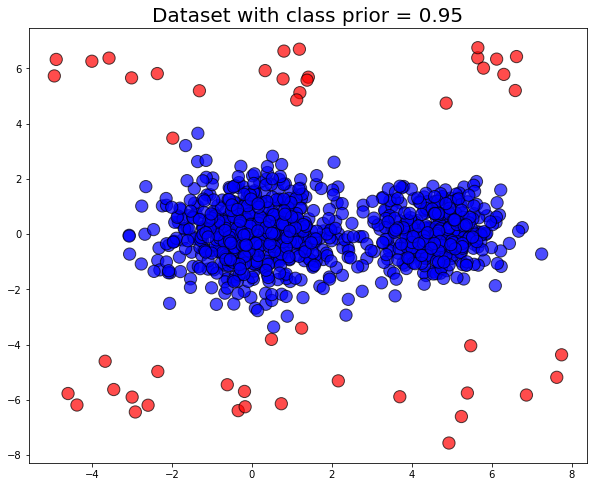

In [15]:
#Plot training and test sets
fig = plt.figure(figsize=(10, 8), facecolor='w', edgecolor='k')
colors = np.array(['b' if y[i] == 0 else 'r' for i in range(n)])# ['g', 'r'])
plt.scatter(X.T[0],X.T[1], 150, colors, alpha = 0.7, edgecolor = 'black')
plt.title("Dataset with class prior = "+str(class_prior), fontsize=20)
plt.show()

Before going to the next step, split the dataset into training and test sets using a stratified split (i.e. the proportion of examples from each class is maintained in training and test sets). Check the page [https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html] to use the method train_test_split.

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify = y)

**Q1**: Why do we need to make a stratified split?

Anomaly detection is usually tackled from an unsupervised perspective because labels are very expensive. Thus, the ground truth $y$ cannot be used for our methods. To overcome the absence of labels, anomaly detection models exploit underlying intuitions about the anomalies and assign a real-valued score to each example that represent its degree of anomalousness (the higher the more anomalous). The model we will use in this session is called kNNO and assigns to each example the distance to its k nearest neightbors as anomaly score.

## k Nearest Neightbors Outlier Detection (KNNO)

Because the implementation of the model is straightforward, we will use the implemented version in PyOD [https://pyod.readthedocs.io/en/latest/index.html]. PyOD is a well noted library for anomaly detection containing all the state of the arts methods.

You first need to install PyOD and import knn:

In [17]:
!pip install pyod
# import kNN from pyod [https://pyod.readthedocs.io/en/latest/_modules/pyod/models/knn.html]
from pyod.models.knn import KNN

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


**Q2:** What is the key insight / underlying intuition behind kNN outlier detection? Why do greater anomaly scores correspond to more anomalous examples? Provide an answer a-priori, i.e. without running the next code.

Let's now experimentally see how kNN outlier detection works. In the documentation of kNN [https://pyod.readthedocs.io/en/latest/_modules/pyod/models/knn.html] you can find the explanation of the native methods supported. In order to extract the anomaly scores, you need first to fit the model on the dataset and then get the attribute `decision_scores_`.

In [34]:
# write your code here:
n_neighbors = 5
contamination = 1-class_prior

ad = KNN(contamination=contamination, n_neighbors=n_neighbors, method='largest')
ad.fit(X_train)
decision_scores = ad.decision_scores_

We now plot the anomaly scores assigned by kNN outlier detection through a heatmap. You just need to make a scatter plot [https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html] and indicate each example with a color that depends on its score (the higher the darker) by passing a color map to the parameter cmap of the scatterplot.

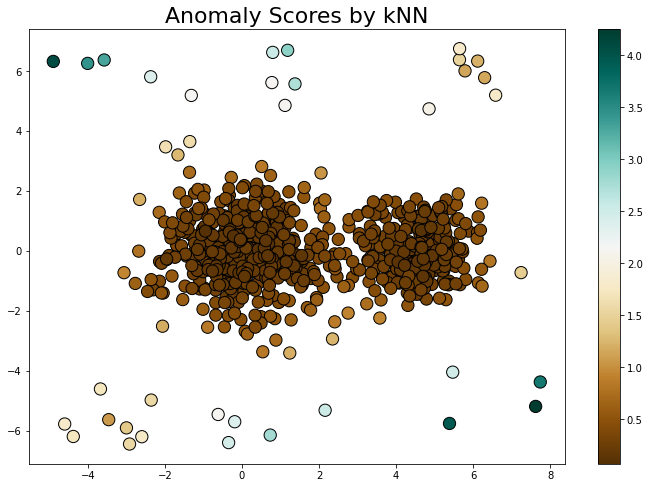

In [35]:
plt.figure(figsize=(12, 8))
cmap = plt.cm.BrBG
# plot the contour
plt.title("Anomaly Scores by kNN", fontsize= 22)
plt.scatter(X_train.T[0], X_train.T[1], s = 150, c=decision_scores, cmap=cmap, edgecolor = 'black')
plt.colorbar()

plt.show()

**Q3:** What are the examples with the greatest anomaly score? Does it follow your intuition of anomalies?

Let's now move on to the prediction. To do inference, anomaly detection models set a threshold on the decision scores according to the contamination factor. Then, they compute the anomaly scores for the test examples and compare the values with the threshold: if the score is above the threshold, then the predicted class is 1 (anomaly), otherwise it is 0 (normal).

Predict the classes of the test examples using kNN and plot the results (use red color for predicted anomalies, and blue for predicted normal).

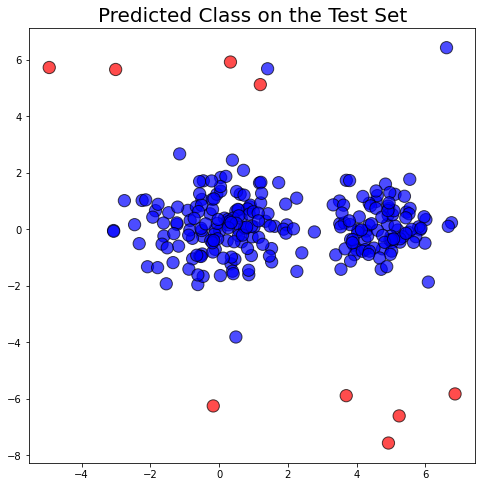

In [36]:
pred = ad.predict(X_test)

#Plot training and test sets
fig = plt.figure(figsize=(8, 8), facecolor='w', edgecolor='k')
colors = np.array(['b' if pred[i] == 0 else 'r' for i in range(len(pred))])# ['g', 'r'])
plt.scatter(X_test.T[0],X_test.T[1], 150, colors, alpha = 0.7, edgecolor = 'black')
plt.title("Predicted Class on the Test Set", fontsize=20)
plt.show()

#### Performance Metrics
We now need to measure the performance of the anomaly detector. Usually, in standard classification tasks a widely used metric is the accuracy. However, in Anomaly Detection there are 2 main metrics: F1 score, and Area Under the ROC Curve (AUC). While the F1 score requires the true labels and the predicted labels as inputs, AUC needs the true label and the anomaly scores (you can compute them by `decision_function(X_test)`).

You can find the documentation of the 2 metrics here: 
- F1 [https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html]
- AUC [https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html]

**Q4:** Why doesn't the accuracy perfectly fit with the anomaly detection setting?

In [37]:
from sklearn.metrics import f1_score, roc_auc_score
f1score = f1_score(y_test, pred)
aucscore = roc_auc_score(y_test, ad.decision_function(X_test))
print("F1 score:", f1score, "AUC:", aucscore)

F1 score: 0.8571428571428571 AUC: 0.9992997198879552


## Active Learning (AL) Strategy: Uncertainty Sampling

Now, we will try to apply an Active Learning strategy on the given dataset. Active Learning is a set of strategy that allows the machine to select the most informative (least certain) examples to query to the user in order to get the feedback with the correct label.

A widely used technique is called Uncertainty Sampling, which consists of querying the examples that have low class-wise posterior probability according to the anomaly detector. When the posterior probabilities are low, both the classes are likely around 50%. You can either take the absolute difference, or `2 * max(class0,class1) - 1` to get the scores normalized.

**Q5:** Implement the Uncertainty Sampling technique. Consider that the posterior probabilities are produced by the model with the method `.predict_proba()`. How to select the least certain predictions?

In [54]:
def uncertainty_sampling(prob):
    #given an array prob containing as first value Prob(Y = 0 |x) and as second value Prob(Y=1|x), 
    #return the uncertainty/informativeness of each example (either the absolute difference of 2*max -1.
    prob_class0 = prob.T[0]
    prob_class1 = prob.T[1]
    
    uncertainty = np.array([2*max(prob_class0[i], prob_class1[i]) -1 for i in range(len(prob))])
    return uncertainty

In [60]:
prob = ad.predict_proba(X_test)
uncertainty = uncertainty_sampling(prob)

Plot the informative scores through an heatmap to visualize the most uncertain examples.

**Q6:** What are the most informative examples?

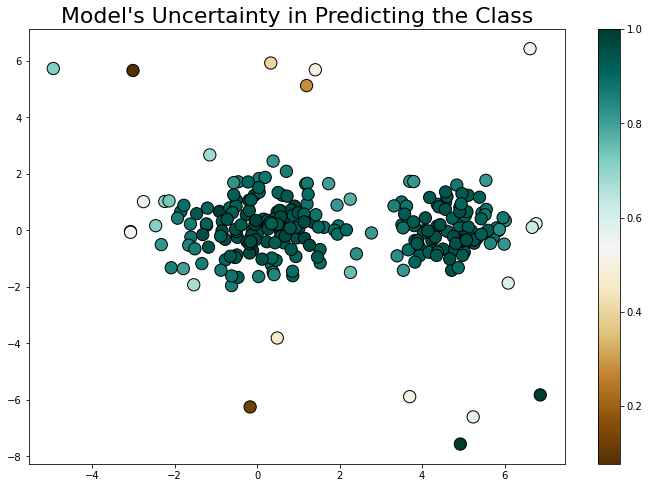

In [61]:
plt.figure(figsize=(12, 8))
cmap = plt.cm.BrBG
# plot the contour
plt.title("Model's Uncertainty in Predicting the Class", fontsize= 22)
plt.scatter(X_test.T[0], X_test.T[1], s = 150, c=uncertainty, cmap=cmap, edgecolor = 'black')
plt.colorbar()
plt.show()

As the last step of this exercise session, we simulate to have a budget of K labels and query the most informative examples. Find the K examples with the lowest scores and collect the label.

**Q7:** Are there more anomalies or normals out of the K collected labels? Is this to be expected?

You can use Counter from collections to count the examples. `Counter(arg)` returns a dictionary with the counts for a key-input.

In [66]:
from collections import Counter
k = 10

idx_uncertainty = np.argsort(uncertainty)
query_ex = idx_uncertainty[:k]

labels = y_test[query_ex]
c = Counter(labels)

print("Number of queried anomalies:", c[1])
print("Number of queried normals:", c[0])

Number of queried anomalies: 8
Number of queried normals: 2


Finally, plot for the last time the dataset giving a color to the queried examples.

**Q8:** Are the misclassified examples included in the list of queried examples? Check the plot with the prediction, and the ground-truth of the test set to see whether the examples with wrong predicted labels are queried to the user. Why should they be queried?

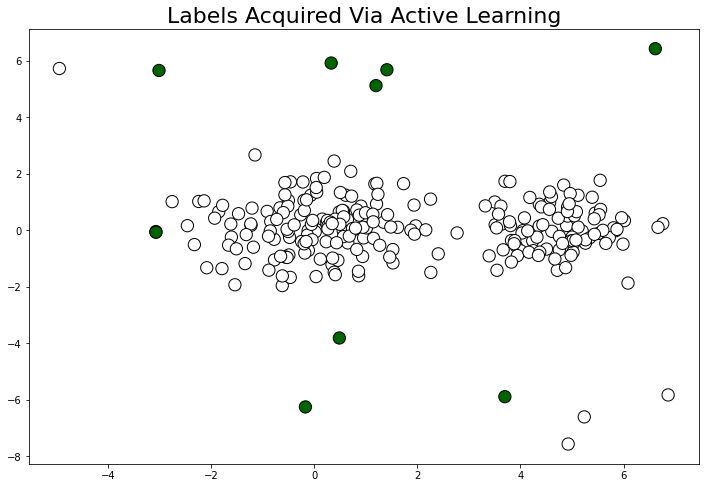

In [67]:
plt.figure(figsize=(12, 8))
# plot the contour
color = ['darkgreen' if i in query_ex else 'white' for i in range(len(X_test))]
plt.title("Labels Acquired Via Active Learning", fontsize= 22)
plt.scatter(X_test.T[0], X_test.T[1], s = 150, c=color, edgecolor = 'black')
plt.show()